In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
class Generator(nn.Module):
    def __init__(self, 
                 out_channels=3,
                 in_channels_latent_dim=100):
        super().__init__()

        self.out_channels = out_channels
        self.latent_dim = in_channels_latent_dim
        
        self.generator = nn.Sequential(

            ### (B x 100 x 1 x 1) -> (B x 1024 x 4 x 4) ###
            nn.ConvTranspose2d(self.latent_dim, 1024, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            ### (B x 1024 x 4 x 4) -> (B x 512 x 8 x 8)###
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            ### (B x 512 x 8 x 8) -> (B x 256 x 16 x 16) ###
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.ReLU(),

            ### (B x 256 x 16 x 16) -> (B x 128 x 32 x 32) ###
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            ### (B x 128 x 32 x 32) -> (B x 3 x 64 x 64) ###
            nn.ConvTranspose2d(128, self.out_channels, kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )

        self.apply(_init_weights)
        
    def forward(self, x):
        return self.generator(x)

class Discriminator(nn.Module):
    def __init__(self,
                 in_channels=3):
        super().__init__()

        self.discriminator = nn.Sequential(

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            ### (B x 3 x 64 x 64) -> (B x 64 x 32 x 32) ###
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0),
        )

        self.apply(_init_weights)

    def forward(self, x):
        batch_size = x.shape[0]
        return self.discriminator(x).reshape(batch_size,1)         

def _init_weights(module):
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(module.weight, 0.0, 0.02)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)



In [3]:
### Training Parameters ###
device = "cuda" if torch.cuda.is_available() else "cpu"
img_size = 64
batch_size = 64
img_channels = 3
latent_dimension = 100
training_epochs = 10
learning_rate = 1e-4

In [4]:
transforms = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        ),
    ]
)
# trainset = torchvision.datasets.MNIST("../../../data", transform=transforms)
# # dataloader = DataLoader(trainset, batch_size=batch_size)

dataset = ImageFolder("../../../data/CelebA/", transform=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
generator = Generator(out_channels=img_channels, 
                      in_channels_latent_dim=latent_dimension).to(device)
discriminator = Discriminator(in_channels=img_channels).to(device)

In [6]:
gen_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

loss_fn = nn.BCEWithLogitsLoss()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch: 0/200 | Generator Loss: 1.751535114849284 | Discriminator Loss: 0.4771658943157669


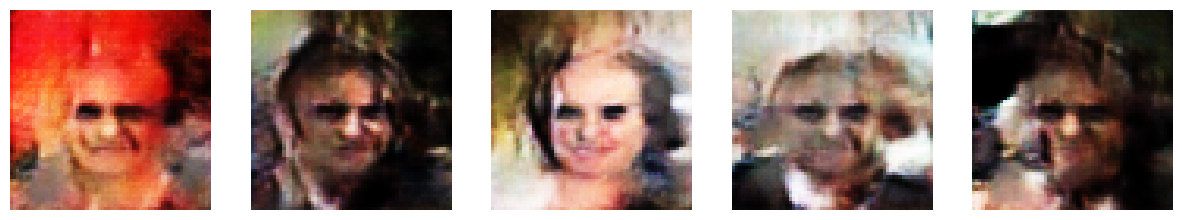

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch: 1/200 | Generator Loss: 1.4315103268508511 | Discriminator Loss: 0.49967647351875233


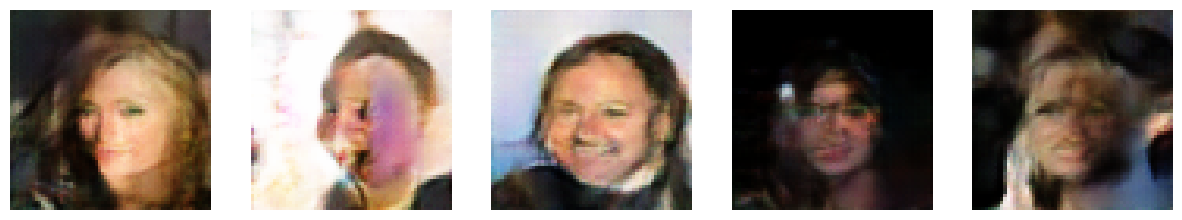

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch: 2/200 | Generator Loss: 1.3268365224732752 | Discriminator Loss: 0.5160622436809751


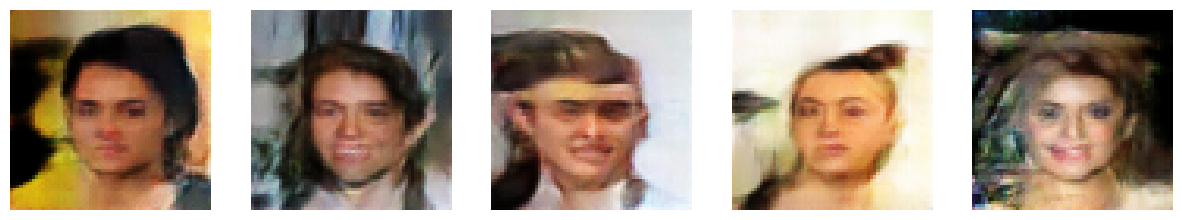

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch: 3/200 | Generator Loss: 1.3449810691653215 | Discriminator Loss: 0.5034063556716929


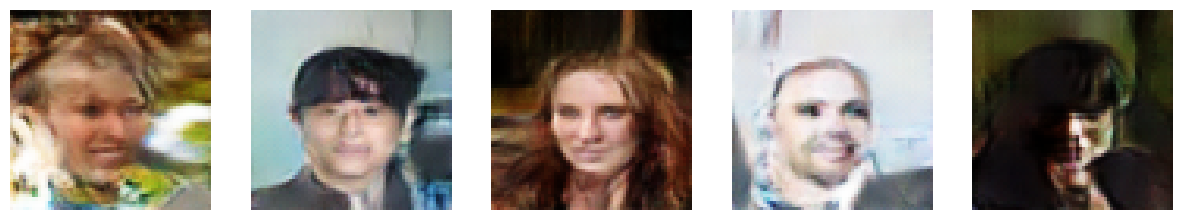

  0%|          | 0/3166 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
def train_unconditional_gan(generator, 
                            discriminator, 
                            generator_optimizer, 
                            discriminator_optimizer, 
                            dataloader,
                            label_smoothing=0.05,
                            epochs=200,
                            device="cpu", 
                            plot_generation_freq=50,
                            plot_loss_freq=20):

    ### Define Loss Function (Will do Sigmoid Internally) ###
    loss_func = nn.BCEWithLogitsLoss()

    gen_losses, disc_losses = [], []
    
    for epoch in tqdm(range(epochs)):
    
        generator_epoch_losses = []
        discriminator_epoch_losses = []
        
        for images, _ in tqdm(dataloader, leave=False):
    
            batch_size = images.shape[0]
    
            ### These are our real images!! ###
            images = images.to(device)
            
            ########################################################## 
            ################ TRAIN DISCRIMINATOR #####################
            ########################################################## 
            
            ### Sample noise for Generation ###
            noise = torch.randn(batch_size, latent_dimension, 1, 1, device=device)

            ### Create Labels for Discriminator with label smoothing ###
            generated_labels = torch.zeros(batch_size, 1, device=device) + label_smoothing
            true_labels = torch.ones(batch_size, 1, device=device) - label_smoothing
    
            ### Generate Samples G(z) and Take Off Computational Graph ###
            generated_images = generator(noise).detach()

            ### Pass Generated and Real Images into Discriminator ###
            real_discriminator_pred = discriminator(images) 
            gen_discriminator_pred = discriminator(generated_images)

            ### Compute Discriminator Loss ###
            real_loss = loss_func(real_discriminator_pred, true_labels)
            fake_loss = loss_func(gen_discriminator_pred, generated_labels)
            discriminator_loss = (real_loss + fake_loss) / 2
            discriminator_epoch_losses.append(discriminator_loss.item())

            ### Update Discriminator ###
            discriminator_optimizer.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()

            ########################################################## 
            ################## TRAIN GENERATOR #######################
            ########################################################## 
            
            ### Sample noise for Generation ###
            noise = torch.randn(batch_size, latent_dimension, 1, 1, device=device)

            ### Generate Images ###
            generated_images = generator(noise)

            ### Pass Into Discriminator (to fool) ###
            gen_discriminator_pred = discriminator(generated_images)

            ### Compute Generator Loss ###
            generator_loss = loss_func(gen_discriminator_pred, true_labels)
            generator_epoch_losses.append(generator_loss.item())

            ### Update the Generator ###
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()
            
        generator_epoch_losses = np.mean(generator_epoch_losses)
        discriminator_epoch_losses = np.mean(discriminator_epoch_losses)
    
        if epoch % plot_loss_freq == 0:
            print(f"Epoch: {epoch}/{epochs} | Generator Loss: {generator_epoch_losses} | Discriminator Loss: {discriminator_epoch_losses}")
    
        gen_losses.append(generator_epoch_losses)
        disc_losses.append(discriminator_epoch_losses)
    
        if epoch % plot_generation_freq == 0:
            generator.eval()
            with torch.no_grad():
                noise_sample = torch.randn(5, latent_dimension, 1, 1, device=device)
                generated_imgs = generator(noise_sample).to("cpu")
        
                fig, ax = plt.subplots(1,5, figsize=(15,5))
        
                for i in range(5):
                    img = (generated_imgs[i].squeeze() + 1)/2

                    if len(img.shape) == 3:
                        img = img.permute(1,2,0)
                        
                    ax[i].imshow(img.numpy(), cmap="gray")
                    ax[i].set_axis_off()
        
                plt.show()
                
            generator.train()

    return generator, discriminator, gen_losses, disc_losses

generator, discriminator, gen_losses, disc_losses = train_unconditional_gan(generator, 
                                                                            discriminator, 
                                                                            gen_optimizer, 
                                                                            disc_optimizer, 
                                                                            dataloader,
                                                                            label_smoothing=0.05,
                                                                            epochs=200,
                                                                            device=device, 
                                                                            plot_generation_freq=1,
                                                                            plot_loss_freq=1)

In [ ]:
# for epoch in range(training_epochs):

#     for batch_idx, (real, _) in enumerate(dataloader):
#         real = real.to(DEVICE)
#         noise = torch.randn(batch_size, latent_dimension, 1, 1).to(DEVICE)
#         fake = generator(noise)

#         ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
#         disc_real = discriminator(real).reshape(-1)
#         loss_disc_real = loss_fn(disc_real, torch.ones_like(disc_real))
#         disc_fake = discriminator(fake.detach()).reshape(-1)
#         loss_disc_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))
#         loss_disc = (loss_disc_real + loss_disc_fake) / 2
#         discriminator.zero_grad()
#         loss_disc.backward()
#         disc_optimizer.step()

#         ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
#         output = discriminator(fake).reshape(-1)
#         loss_gen = loss_fn(output, torch.ones_like(output))
#         generator.zero_grad()
#         loss_gen.backward()
#         gen_optimizer.step()

#         # Print losses occasionally and print to tensorboard
#         if batch_idx % 100 == 0:
#             print(
#                 f"Epoch [{epoch}/{training_epochs}] Batch {batch_idx}/{len(dataloader)} \
#                   Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
#             )

#             with torch.no_grad():
#                 fake = generator(noise)
#                 # take out (up to) 32 examples
#                 img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
#                 img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                
#                 plt.imshow(img_grid_fake.cpu().permute(1,2,0))
#                 plt.show()
